In [1]:
import pandas as pd
import numpy
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
#plt.style.use('ggplot')
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import scipy
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import joblib
from scipy.integrate import simps
from datetime import datetime
import sklearn.metrics as metrics
from xgboost import XGBClassifier
from sklearn import tree

def norm_minimax(datos_train, datos_test=None, splits=True, mini=None, maxi=None):
    if (mini is None) and (maxi is None):
        maxi=(np.max(datos_train))
        mini=(np.min(datos_train))
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train, mini, maxi
    if (mini is not None) & (maxi is not None) & (splits==True):
        datos_train = (datos_train-mini)/(maxi-mini)
        datos_test = (datos_test-mini)/(maxi-mini)
        return datos_train, datos_test
    if (mini is not None) & (maxi is not None) & (splits==False):
        datos_train = (datos_train-mini)/(maxi-mini)
        return datos_train
    print('Error de entradas en nomalizacion minimax')
    return -1

# calcular peso de clase para darselo al modelo
def pesos_clases(y_train, only_pos=False):
    cant_refa = 0
    cant_norefa = 0
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            cant_refa = cant_refa + 1
        else:
            cant_norefa = cant_norefa + 1
    total = cant_norefa + cant_refa
    porcentaje_refa = (cant_refa/total)*100
    print('Porcentaje de refacturas: %0.2f' % porcentaje_refa)
    weight_for_0 = (1 / cant_norefa)*(total)/2.0 
    weight_for_1 = ((1 / cant_refa)*(total)/2.0) #/2 #dividido 2 para que no haya tantos falsos positivos
    class_weight = {0: weight_for_0, 1: weight_for_1}
    initial_bias = np.log([cant_refa/cant_norefa])
    #weight = cant_norefa/cant_refa
    print('Peso de clase "0" (sin refactura): {:.2f}'.format(weight_for_0))
    print('Peso de clase "1" (con refactura): {:.2f}'.format(weight_for_1))
    print('Bias inicial: ',initial_bias)
    if only_pos==False:
        return weight_for_0, weight_for_1, initial_bias
    else:
        return weight_for_1

def curva_ROC(fpr, tpr, roc_auc):  
    # method I: plt
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'--', color='RoyalBlue')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    #plt.savefig("ROC" + str(w) + '-' + T + ".jpg")
    plt.show()

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y, umbral=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", cmap='Blues');
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    #plt.savefig("matriz_confusion" + str(w) + '-' + T + ".jpg")
    plt.show()
    #print (classification_report(y_test, pred_y))
    
def MOSTRAR_METRICAS(y_test, pred_y, umbral=None, beta=None):
    for i in range(0, len(pred_y)):
        if pred_y[i] > umbral:
            pred_y[i] = 1
        else:
            pred_y[i] = 0
    [TN, FP],[FN,TP] = confusion_matrix(y_test, pred_y)
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    f1_score = (2*recall*precision) / (recall + precision)
    g_mean = np.sqrt((TP / (TP + FN)) * (TN / (TN + FP)))
    print('Recall: %0.4f' % recall)
    print('Precision: %0.4f' % precision)
    print('F1-score: %0.4f' % f1_score)
    print('G-mean: %0.4f' % g_mean)
    if beta is not None:
        f_beta = (((1 + beta)**2) * recall * precision) / (((beta**2) * precision) + recall)
        print('F-measure: %0.4f' % f_beta)
        return recall, precision, f1_score, g_mean, f_beta
    return recall, precision, f1_score, g_mean
        
def AUCM_PLOT(archivo):
    # Calculo de porcentajes
    porc_TD = numpy.arange(0, 1.01, 0.01)
    porc_TR = numpy.arange(0, 1.01, 0.01)
    j = 0
    maximo = 0
    limite_pasado = False
    for umbral in numpy.arange(0, 1.01, 0.01):
        predprob_y = joblib.load(archivo)
        for i in range(0, len(predprob_y)):
            if predprob_y[i] > umbral:
                predprob_y[i] = 1
            else:
                predprob_y[i] = 0
        [TN, FP],[FN,TP] = confusion_matrix(y_test, predprob_y)
        porc_TD[j] = (TP + FP) / (TP + FP + TN + FN)
        porc_TR[j] = TP / (TP + FN)
        if maximo < (porc_TR[j] - porc_TD[j]):
            maximo = umbral
            maximo_registros = TP + FP
        if ((TP+FP) < 3500) & (limite_pasado==False):
            limite_umbral = umbral
            limite_refactura = porc_TR[j]
            revisar = TP + FP
            limite_pasado = True
        j+=1
        #print('interacion de: ', umbral)
    umbral = numpy.arange(0, 1.01, 0.01)
    # Calculo de areas
    rocm_total = simps(porc_TD, umbral)
    rocm_refa = simps(porc_TR, umbral)
    AUCM = rocm_refa - rocm_total
    print('AUCM = %0.5f' % AUCM)
    #grafica
    plt.figure(figsize=(5, 5))
    plt.title('Receiver Operating Characteristic Modified (ROCM)')
    plt.plot(umbral, porc_TD, 'b', label = 'AUC Total = %0.4f' % rocm_total, color='indianred')
    plt.legend(loc = 'lower right')
    plt.plot(umbral, porc_TR, 'b', label = 'AUC Refacturas = %0.4f' % rocm_refa, color='DarkSeaGreen')
    plt.legend(loc = 'lower right')
    plt.xlim([1.01, -0.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('% del Total')
    plt.xlabel('% probabilidad de refactura desde')
    plt.legend()
    #plt.savefig("ROCM" + str(w) + '-' + T + ".jpg")
    plt.show()
    return limite_umbral, limite_refactura, revisar, maximo, maximo_registros, AUCM

def Carga_Datos(archivo=None, limpia=False):
    if limpia==True:
        if len(archivo)>1:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA_TERRENO': 'float32', 'CLAVE_TERRENO': 'str',
                     'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32', 'CATEGORIA': 'str',
                     'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str', 'RECORR1': 'str',
                     'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str', 
                     'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 
                     'TIENE_REFA': 'float32'}
            data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
            Data = pd.concat([data1, data2], ignore_index=True)
            del data1
            del data2
            Data = Data.drop('Unnamed: 0', axis=1)
        else:
            dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
                     'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
                     'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
                     'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
                     'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
                     'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32',
                     'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'ANALISTA': 'float32', 'TIENE_REFA': 'float32'}
            Data = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
            #Data = Data.drop('Unnamed: 0', axis=1)
        print('Se Cargo base de datos')
        return Data
    #Se agrega el tipo de variable de cada colunma para visualización
    dtype = {'NRO_SUMINISTRO': 'str', 'COD_DIAMETRO': 'str', 'LECTURA': 'float32', 'LECTURA_TERRENO': 'float32',
             'CLAVE_TERRENO': 'str', 'LECTURA_ANT': 'float32', 'CONSUMO_BASE': 'float32', 'CONSUMO_PROM': 'float32',
             'CATEGORIA': 'str', 'TIP_DOCUMENTO': 'str', 'COD_LECTOR': 'str', 'COD_OBS': 'str', 'COD_LOCALIDAD': 'str',
             'RECORR1': 'str', 'RECORR2': 'str', 'TIE_REMAR': 'str', 'ID_RELACION': 'str', 'COD_EMPRESA': 'str',
             'CLAVE_LECTURA': 'str', 'CLAVE_TERRENO_MES_ANT': 'str', 'CONS_BASE_MES_ANT': 'float32', 'COD_OBS_MES_ANT': 'str',
             'CLAVE_TERRENO_MISMO_MES_ANNO_ANT': 'str', 'CONS_BASE_MISMO_MES_ANNO_ANT': 'float32', 
             'COD_OBS_MISMO_MES_ANNO_ANT': 'str', 'ANNO': 'str', 'MES': 'str', 'TIENE_REFA': 'float32'}
    #se leen los datos
    data1 = pd.read_csv(archivo[0], delimiter=';', dtype=dtype, low_memory=False)
    data2 = pd.read_csv(archivo[1], delimiter=';', dtype=dtype, low_memory=False)
    #se encadenan todos los chunks en una tabla
    Data = pd.concat([data1, data2], ignore_index=True)
    del data1
    del data2
    data3 = pd.read_csv(archivo[2], delimiter=';', dtype=dtype, low_memory=False)
    Data = pd.concat([Data, data3], ignore_index=True)
    del data3
    Data = Data.drop([len(Data)-1],axis=0)
    #Reemplazo de nulos -------------------------------------------------------------------------------------------------------
    Data['COD_DIAMETRO']=Data['COD_DIAMETRO'].fillna('13')
    Data['CATEGORIA']=Data['CATEGORIA'].fillna('R')
    Data['COD_LECTOR']=Data['COD_LECTOR'].fillna('0')
    Data['TIE_REMAR']=Data['TIE_REMAR'].fillna('N')
    Data['COD_OBS']=Data['COD_OBS'].fillna('ACE')
    Data['COD_OBS_MES_ANT']=Data['COD_OBS_MES_ANT'].fillna('ACE')
    Data['COD_OBS_MISMO_MES_ANNO_ANT']=Data['COD_OBS_MISMO_MES_ANNO_ANT'].fillna('ACE')
    Data['CLAVE_TERRENO_MES_ANT']=Data['CLAVE_TERRENO_MES_ANT'].fillna('N')
    Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT']=Data['CLAVE_TERRENO_MISMO_MES_ANNO_ANT'].fillna('N')
    Data['CONSUMO_BASE']=Data['CONSUMO_BASE'].fillna(0)
    Data['CONS_BASE_MES_ANT']=Data['CONS_BASE_MES_ANT'].fillna(0)
    #pre-procesamiento de algunas columnas ------------------------------------------------------------------------------------
    Data.CATEGORIA = Data.CATEGORIA.replace({"G": 'R', "1": 'R', "O": 'F'})
    Data.COD_DIAMETRO = Data.COD_DIAMETRO.replace({"13": '013'})
    Data = Data.drop(Data[Data['CATEGORIA']=='F'].index)
    #Filtrado casos atipicos 03-2016 LISTO -------------------------------------------------------------------------------------
    Data = Data.drop(Data[(Data['MES']=='3') & (Data['ANNO']=='2016')].index)
    #Data = Data.drop(Data[((Data['MES']=='3') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='DXS') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CXS') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='BYP')) &
    #                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='R'))
    #                     ].index)
    #Filtrado casos atipicos 10-2016 LISTO
    Data = Data.drop(Data[(Data['MES']=='10') & (Data['ANNO']=='2016')].index)
    #Data = Data.drop(Data[((Data['MES']=='10') & (Data['ANNO']=='2016') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CVE')) &
    #                      (Data['CLAVE_TERRENO']=='N')].index)
    #Filtrado casos atipicos 05-2017 LISTO
    Data = Data.drop(Data[(Data['MES']=='5') & (Data['ANNO']=='2017')].index)
    #Data = Data.drop(Data[((Data['MES']=='5') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['RECORR1']=='08')|(Data['RECORR1']=='07')|(Data['RECORR1']=='06')|(Data['RECORR1']=='05')|
    #                       (Data['RECORR1']=='04')|(Data['RECORR1']=='03')|(Data['RECORR1']=='02')|(Data['RECORR1']=='01')) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='CVA')) &
    #                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P'))].index)
    #Filtrado casos atipicos 06-2017
    Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2017')].index)
    #Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2017') & (Data['COD_EMPRESA']=='2') & (Data['TIENE_REFA']==1)) &
    #                      ((Data['RECORR1']=='09')|(Data['RECORR1']=='10')|(Data['RECORR1']=='11')|(Data['RECORR1']=='12')|
    #                       (Data['RECORR1']=='13')|(Data['RECORR1']=='14')|(Data['RECORR1']=='15')|(Data['RECORR1']=='16')|
    #                       (Data['RECORR1']=='17')|(Data['RECORR1']=='18')|(Data['RECORR1']=='19')|(Data['RECORR1']=='20')) &
    #                      ((Data['COD_OBS']=='ACE') | (Data['COD_OBS']=='CC') | (Data['COD_OBS']=='DHS') | (Data['COD_OBS']=='CVE') | (Data['COD_OBS']=='LAM') | (Data['COD_OBS']=='ASM') | (Data['COD_OBS']=='SUS') | (Data['COD_OBS']=='DPU') | (Data['COD_OBS']=='LDE')) &
    #                      ((Data['CLAVE_TERRENO']=='N') | (Data['CLAVE_TERRENO']=='2') | (Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='8') | (Data['CLAVE_TERRENO']=='3') | (Data['CLAVE_TERRENO']=='I') | (Data['CLAVE_TERRENO']=='L') | (Data['CLAVE_TERRENO']=='P') | (Data['CLAVE_TERRENO']=='T'))].index)
    #Filtrado casos atipicos 06-2018 LISTO
    Data = Data.drop(Data[(Data['MES']=='6') & (Data['ANNO']=='2018')].index)
    #Data = Data.drop(Data[((Data['MES']=='6') & (Data['ANNO']=='2018') & (Data['COD_EMPRESA']=='1') & (Data['TIENE_REFA']==1)) &
    #                      (Data['COD_OBS']=='CC') &
    #                      ((Data['CLAVE_TERRENO']=='1') | (Data['CLAVE_TERRENO']=='2'))].index)
    #Reordenar los indices de dataframe
    Data = Data.reset_index(drop=True)
    #Agregar columna de responsabilidad del analista --------------------------------------------------------------------------
    Data.insert(len(Data.columns)-1, 'ANALISTA', 0)
    #codigos de responsabilidad del analista
    Data.loc[Data['CLAVE_LECTURA'] == 'P', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'A', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'B', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'C', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'G', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'M', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'O', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'W', 'ANALISTA'] = 1
    Data.loc[Data['CLAVE_LECTURA'] == 'Z', 'ANALISTA'] = 1
    
    print('Se Cargo base de datos')
    return Data

#def Preprocesamiento_Datos(Data, codigo_empresa=None, anno=None, ohe=None, mini=None, maxi=None, le=None):
def Preprocesamiento_Datos(Data, splits=True, ohe=None, mini=None, maxi=None, SS=None, SS_num=None, le=None):
    if (ohe is None) and (mini is None) and (maxi is None) and (SS is None) and (SS_num is None) and (le is None):
    #if (ohe is None) and (mini is None) and (maxi is None) and (le is None):
        codificacion=True
    else:
        codificacion=False
    
    #eliminacion de algunas columnas que no sirven
    Data = Data.drop('NRO_SUMINISTRO', axis=1)
    Data = Data.drop('COD_LECTOR', axis=1)
    Data = Data.drop('ANNO', axis=1)
    
    #guardar columnas que sean float
    columnas = Data.columns
    col = np.zeros(len(Data.columns))
    j = 0
    for i in columnas:
        if Data[i].dtype == 'f':
            col[j] = 1
        j = j + 1
            
    Dataset = Data.values
    del Data
            
    x_train = Dataset[:, :-1]
    y_train = Dataset[:,-1]
    del Dataset
    x_train = x_train.astype(str)
    y_train = y_train.reshape((len (y_train), 1))

    #Splits
    if (codificacion==False) & (splits==True):
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3,train_size=0.7)
        print('Splits listos')
    ######################################################################################################################
    #Preparar datos para codificacion
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #Separar datos numericos de categoricos
    init = 0
    k = 0
    for i in range(0, len(col)-1):
        if col[i] == 1:
            if init == 2:
                x_train_num = np.append(x_train_num, [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append(x_test_num, [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
            if init == 1:
                x_train_num = np.append([x_train_num], [x_train[k]], axis=0)
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = np.append([x_test_num], [x_test[k]], axis=0)
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 2
            if init == 0:
                x_train_num = x_train[k]
                x_train = np.delete(x_train, k, axis=0)
                if (codificacion==False) & (splits==True):
                    x_test_num = x_test[k]
                    x_test = np.delete(x_test, k, axis=0)
                k = k - 1
                init = 1
            k = k + 1
        else:
            k = k + 1
    
    #codificacion OneHot para datos categorios ---------------------------------------------------------------------------
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    if ohe is None:
        ohe = OneHotEncoder(dtype='float16',handle_unknown='ignore')
        ohe.fit(x_train)
    
    x_train = ohe.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = ohe.transform(x_test)
    
    #StandarScaler, podria ocuparse, pero pensandolos bien no tiene mucho sentido 
    if SS is None:
        SS = StandardScaler(with_mean=False)
        SS.fit(x_train) 
    x_train = SS.transform(x_train)
    if (codificacion==False) & (splits==True):
        x_test = SS.transform(x_test)
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
            
    #estandarizacion minimax para datos numericos ----------------------------------------------------------------------
    x_train_num = x_train_num.astype('float')
    if (codificacion==False) & (splits==True):
        x_test_num = x_test_num.astype('float')
    
    if (mini is None) & (maxi is None):
        mini = np.zeros(len(x_train_num))
        maxi = np.zeros(len(x_train_num))
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], mini[i], maxi[i] = norm_minimax(datos_train=x_train_num[:,i], splits=False)
    if (mini is not None) & (maxi is not None) & (splits==True):
        for i in range(0, len(x_train_num)):
            x_train_num[:,i], x_test_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], datos_test=x_test_num[:,i],
                                                            mini=mini[i], maxi=maxi[i])
    if (mini is not None) & (maxi is not None) & (splits==False):
        for i in range(0, len(x_train_num)):
            x_train_num[:,i] = norm_minimax(datos_train=x_train_num[:,i], splits=False, mini=mini[i], maxi=maxi[i])
    
    
    #StandarScaler, podria ocuparse, pero pensandolos bien no tiene mucho sentido    
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    if SS_num is None:
        SS_num = StandardScaler()
        SS_num.fit(x_train_num)
    x_train_num = SS_num.fit_transform(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = SS_num.transform(x_test_num)
    x_train_num = np.transpose(x_train_num)
    if (codificacion==False) & (splits==True):
        x_test_num = np.transpose(x_test_num)
    
    #volver a unir los datos -------------------------------------------------------------------------------------------
    x_train = scipy.sparse.vstack((x_train, x_train_num))
    del x_train_num
    if (codificacion==False) & (splits==True):
        x_test = scipy.sparse.vstack((x_test, x_test_num))
        del x_test_num
    
    x_train = np.transpose(x_train)
    if (codificacion==False) & (splits==True):
        x_test = np.transpose(x_test)
    
    #codificar las etiquetas ---------------------------------------------------------------------------------------------
    if le is None:
        le = LabelEncoder()
        le.fit(y_train)
     
    y_train = le.transform(y_train)
    if (codificacion==False) & (splits==True):
        y_test = le.transform(y_test)
    
    print('Codificacion lista')
    print('Dimensiones datos: ',x_train.shape)
    print('Dimensiones etiquetas: ',y_train.shape)
    
    if (codificacion==False) & (splits==True):
        return x_train, x_test, y_train, y_test
    
    if (codificacion==False) & (splits==False):
        return x_train, y_train
    
    if codificacion==True:
        #Guardar tranformaciones de datos
        joblib.dump(ohe, 'ohe.pkl')
        joblib.dump(mini, 'mini.pkl')
        joblib.dump(maxi, 'maxi.pkl')
        joblib.dump(SS, 'SS.pkl')
        joblib.dump(SS_num, 'SS_num.pkl')
        joblib.dump(le, 'le.pkl')
        return x_train, y_train, ohe, mini, maxi, SS, SS_num, le
    
    else: 
        print('Error en argumentos de funcion de pre-procesamiento de datos')
        return -1
    #----------------------------------------------------------------------------------------------------------------------
    
#metricas ha ocupar
metricas = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]
print('librerias y funciones listas')

librerias y funciones listas


In [2]:
start_time = datetime.now()
#Carga datos
archivo = ['../data-analista2016-2018v3.csv']
#archivo = ['../chunk1_Data_noanalista2016-2018.csv', '../chunk2_Data_noanalista2016-2018.csv']
#archivo = ['../chunk1_2016-2018v3.csv', '../chunk2_2016-2018v3.csv', '../chunk3_2016-2018v3.csv']
Data = Carga_Datos(archivo=archivo, limpia=True)

#Creacion de data train y test (diciembre 2018)
Data_test1 = Data.drop(Data[(Data['MES']!='12') | (Data['ANNO']!='2018')].index)
Data = Data.drop(Data[(Data['MES']=='12') & (Data['ANNO']=='2018')].index)

print('Division de datos lista')

Se Cargo base de datos
Division de datos lista


In [3]:
#pre-procesamiento de datos y carga de codificaciones
ohe = joblib.load('../ohe.pkl')
mini = joblib.load('../mini.pkl')
maxi = joblib.load('../maxi.pkl')
SS = joblib.load('../SS.pkl')
SS_num = joblib.load('../SS_num.pkl')
le = joblib.load('../le.pkl')
x_train, y_train = Preprocesamiento_Datos(Data, splits=False,
                                          ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le)
del Data
#calcular pesos de cada clase para darselo al modelo
weight_for_0, weight_for_1, initial_bias = pesos_clases(y_train) 
class_weight = {0: weight_for_0, 1: weight_for_1} 
# Crear Arbol de decision 
decision_tree = tree.DecisionTreeClassifier(criterion='gini',  #o entropy
                                            min_samples_split=500,
                                            min_samples_leaf=500,
                                            max_depth = 250,
                                            #max_leaf_nodes = 50,
                                            class_weight=class_weight) #buen modelo con 25

print('Se empieza a entrenar el arbol')
decision_tree.fit(x_train, y_train)
print('Se entreno el arbol')
del x_train, y_train, ohe, mini, maxi, SS, SS_num, le
print('Se entreno el modelo')
# save the model to disk
filename = 'model_DT_DA_sindiv.sav'
joblib.dump(decision_tree, filename)
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (1190525, 846)
Dimensiones etiquetas:  (1190525,)
Porcentaje de refacturas: 1.72
Peso de clase "0" (sin refactura): 0.51
Peso de clase "1" (con refactura): 29.10
Bias inicial:  [-4.04649202]
Se empieza a entrenar el arbol
Se entreno el arbol
Se entreno el modelo
Time elapsed (hh:mm:ss.ms) 0:05:53.908482


In [4]:
# load the model from disk
#model_XGB = joblib.load('model_XGB_V2.sav')

### Resultados DIC18

Sector de facturacion 01


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (1955, 846)
Dimensiones etiquetas:  (1955,)


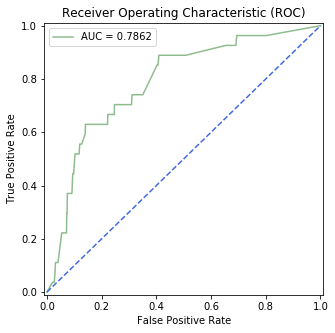

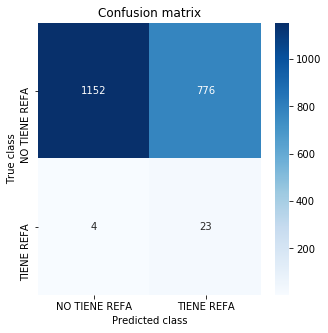

Recall: 0.8519
Precision: 0.0288
F1-score: 0.0557
G-mean: 0.7134
F-measure: 0.7372
AUCM = 0.34391


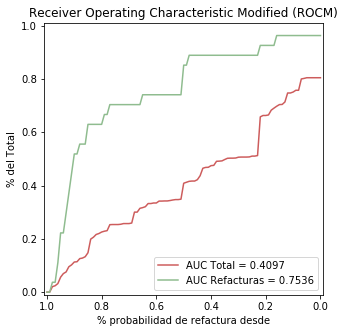

Porcentaje de Refacturas revisadas en limite de analista (3500) es 96.30% con un total de 1573 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.85% con un total de 289 registros a revisar.

Sector de facturacion 02
Codificacion lista
Dimensiones datos:  (2663, 846)
Dimensiones etiquetas:  (2663,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


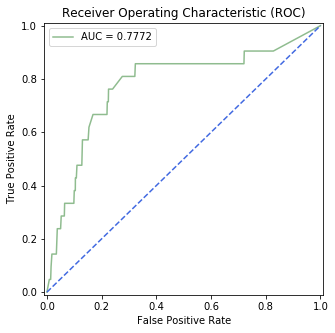

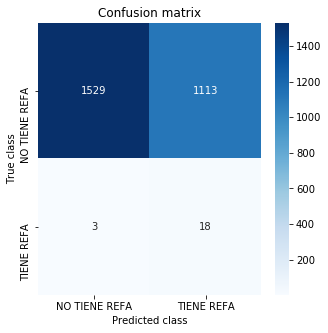

Recall: 0.8571
Precision: 0.0159
F1-score: 0.0312
G-mean: 0.7043
F-measure: 0.5891
AUCM = 0.34700


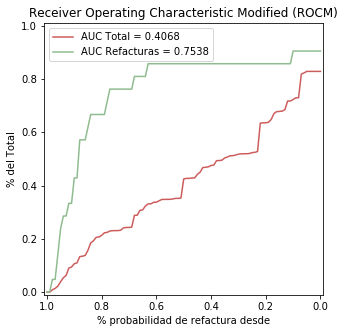

Porcentaje de Refacturas revisadas en limite de analista (3500) es 90.48% con un total de 2206 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.59% con un total de 913 registros a revisar.

Sector de facturacion 03
Codificacion lista
Dimensiones datos:  (2780, 846)
Dimensiones etiquetas:  (2780,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


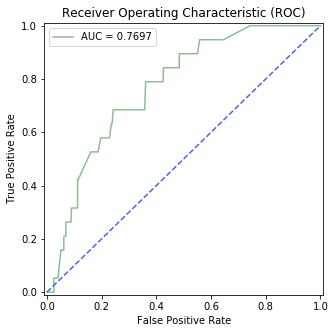

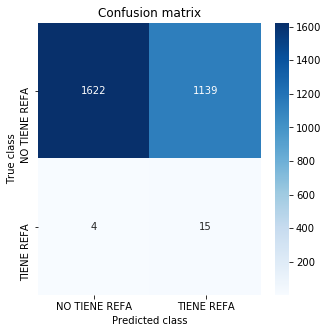

Recall: 0.7895
Precision: 0.0130
F1-score: 0.0256
G-mean: 0.6810
F-measure: 0.5127
AUCM = 0.31729


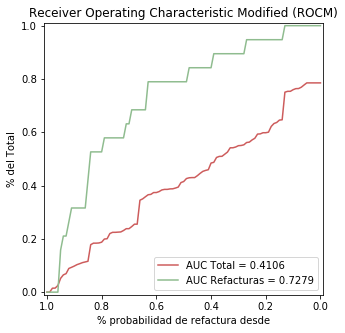

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 2183 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.44% con un total de 1239 registros a revisar.

Sector de facturacion 04
Codificacion lista
Dimensiones datos:  (2160, 846)
Dimensiones etiquetas:  (2160,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


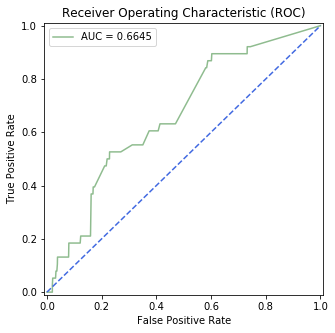

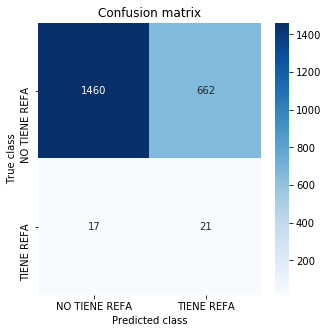

Recall: 0.5526
Precision: 0.0307
F1-score: 0.0583
G-mean: 0.6166
F-measure: 0.5461
AUCM = 0.18716


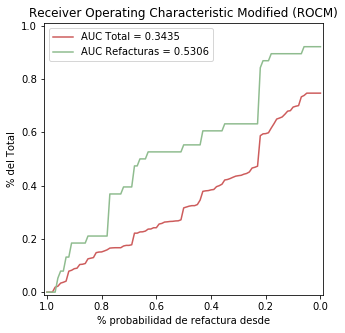

Porcentaje de Refacturas revisadas en limite de analista (3500) es 92.11% con un total de 1613 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.39% con un total de 832 registros a revisar.

Sector de facturacion 05
Codificacion lista
Dimensiones datos:  (2265, 846)
Dimensiones etiquetas:  (2265,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


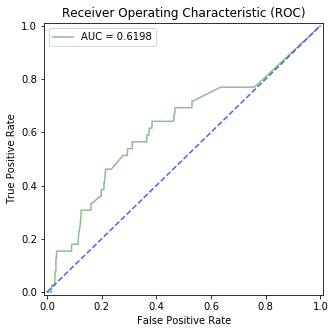

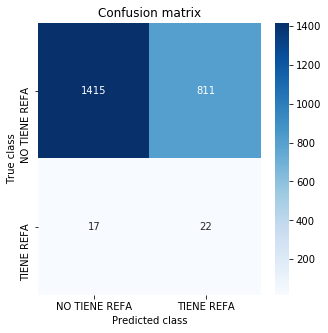

Recall: 0.5641
Precision: 0.0264
F1-score: 0.0505
G-mean: 0.5988
F-measure: 0.5353
AUCM = 0.15592


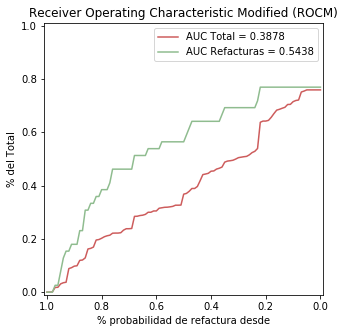

Porcentaje de Refacturas revisadas en limite de analista (3500) es 76.92% con un total de 1719 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.45% con un total de 898 registros a revisar.

Sector de facturacion 06


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (2984, 846)
Dimensiones etiquetas:  (2984,)


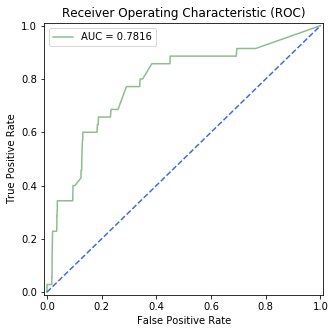

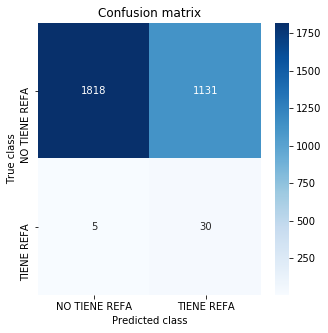

Recall: 0.8571
Precision: 0.0258
F1-score: 0.0502
G-mean: 0.7269
F-measure: 0.7145
AUCM = 0.34378


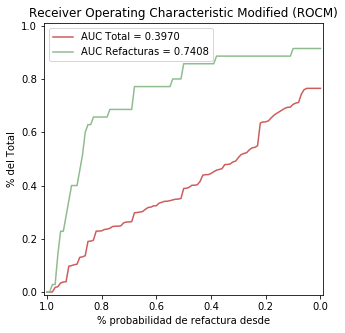

Porcentaje de Refacturas revisadas en limite de analista (3500) es 91.43% con un total de 2282 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.48% con un total de 1174 registros a revisar.

Sector de facturacion 07
Codificacion lista
Dimensiones datos:  (2640, 846)
Dimensiones etiquetas:  (2640,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


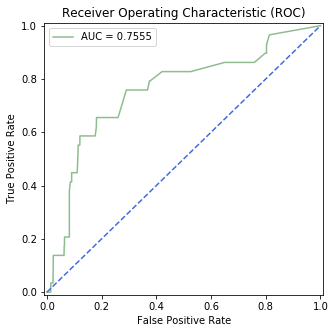

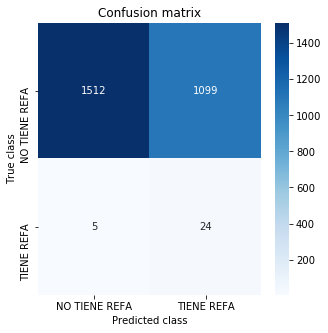

Recall: 0.8276
Precision: 0.0214
F1-score: 0.0417
G-mean: 0.6923
F-measure: 0.6526
AUCM = 0.30225


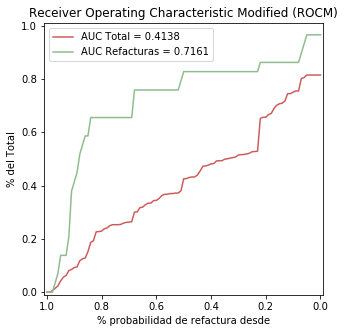

Porcentaje de Refacturas revisadas en limite de analista (3500) es 96.55% con un total de 2151 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.66% con un total de 837 registros a revisar.

Sector de facturacion 08
Codificacion lista
Dimensiones datos:  (2452, 846)
Dimensiones etiquetas:  (2452,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


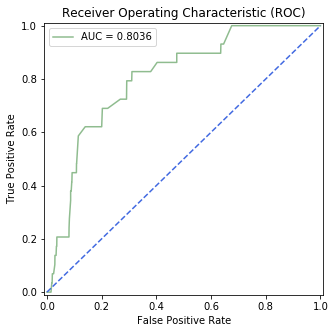

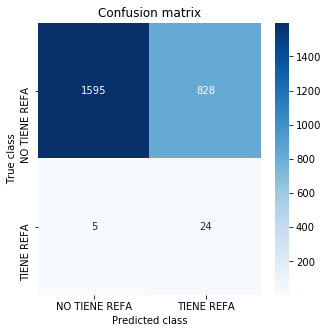

Recall: 0.8276
Precision: 0.0282
F1-score: 0.0545
G-mean: 0.7381
F-measure: 0.7179
AUCM = 0.37502


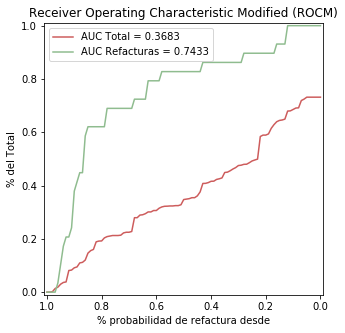

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1794 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.52% con un total de 796 registros a revisar.

Sector de facturacion 09
Codificacion lista
Dimensiones datos:  (2214, 846)
Dimensiones etiquetas:  (2214,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


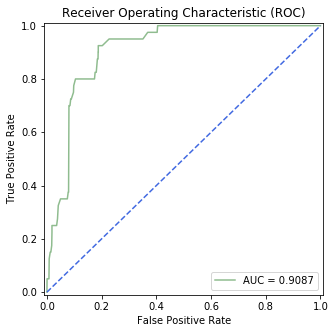

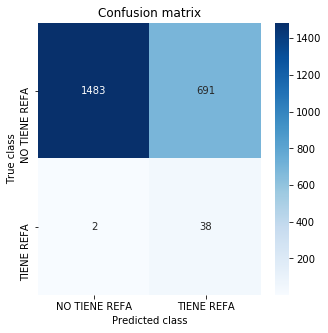

Recall: 0.9500
Precision: 0.0521
F1-score: 0.0988
G-mean: 0.8050
F-measure: 0.9358
AUCM = 0.50861


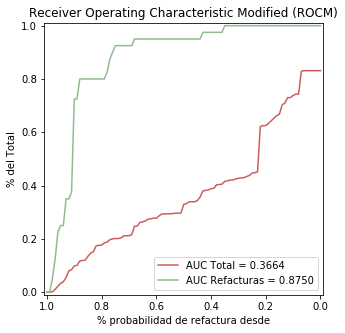

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1840 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.73% con un total de 449 registros a revisar.

Sector de facturacion 10
Codificacion lista
Dimensiones datos:  (2204, 846)
Dimensiones etiquetas:  (2204,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


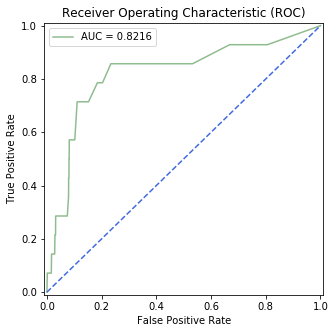

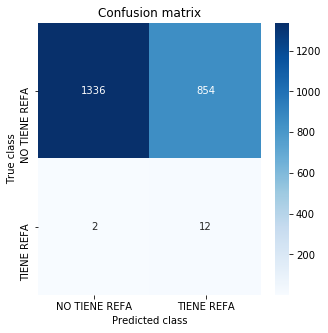

Recall: 0.8571
Precision: 0.0139
F1-score: 0.0273
G-mean: 0.7231
F-measure: 0.5516
AUCM = 0.39376


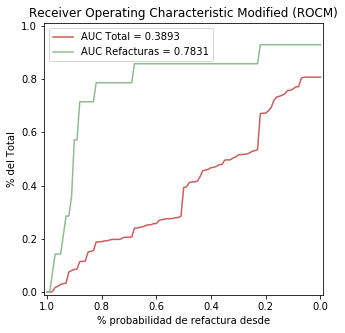

Porcentaje de Refacturas revisadas en limite de analista (3500) es 92.86% con un total de 1778 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.62% con un total de 557 registros a revisar.

Sector de facturacion 11
Codificacion lista
Dimensiones datos:  (2269, 846)
Dimensiones etiquetas:  (2269,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


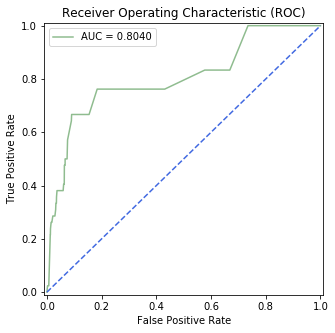

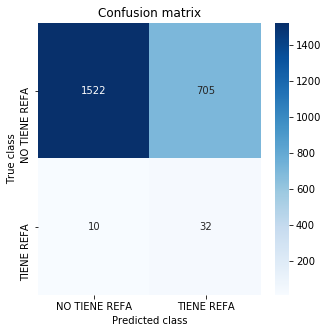

Recall: 0.7619
Precision: 0.0434
F1-score: 0.0822
G-mean: 0.7216
F-measure: 0.7568
AUCM = 0.38387


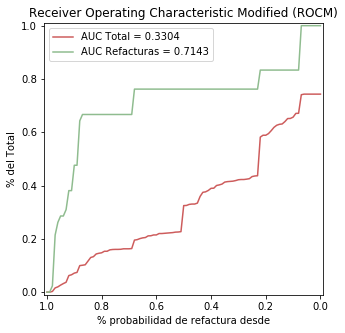

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1686 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.66% con un total de 456 registros a revisar.

Sector de facturacion 12
Codificacion lista
Dimensiones datos:  (1704, 846)
Dimensiones etiquetas:  (1704,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


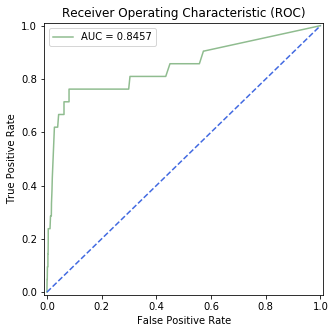

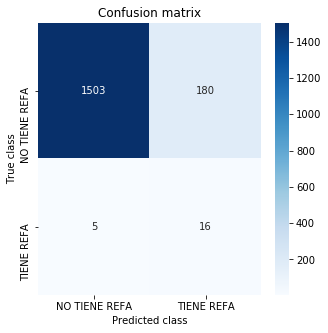

Recall: 0.7619
Precision: 0.0816
F1-score: 0.1475
G-mean: 0.8249
F-measure: 0.8416
AUCM = 0.48716


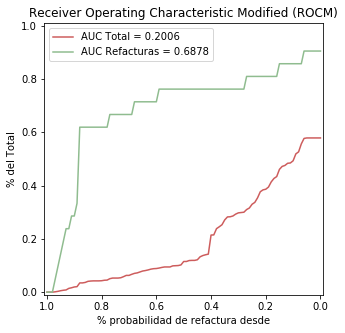

Porcentaje de Refacturas revisadas en limite de analista (3500) es 90.48% con un total de 986 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.67% con un total de 123 registros a revisar.

Sector de facturacion 13
Codificacion lista
Dimensiones datos:  (1915, 846)
Dimensiones etiquetas:  (1915,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


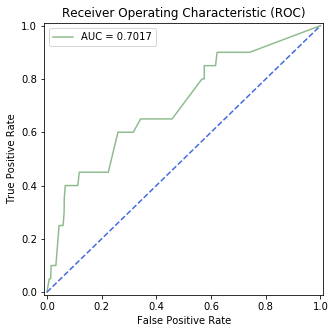

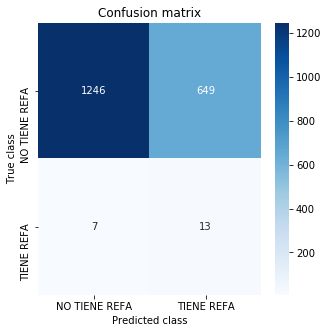

Recall: 0.6500
Precision: 0.0196
F1-score: 0.0381
G-mean: 0.6537
F-measure: 0.5422
AUCM = 0.23903


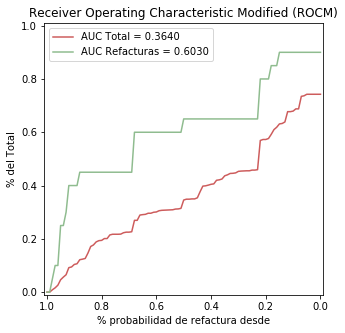

Porcentaje de Refacturas revisadas en limite de analista (3500) es 90.00% con un total de 1422 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.36% con un total de 813 registros a revisar.

Sector de facturacion 14
Codificacion lista
Dimensiones datos:  (1875, 846)
Dimensiones etiquetas:  (1875,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


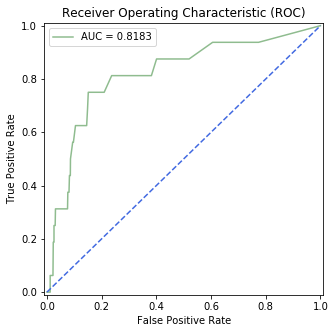

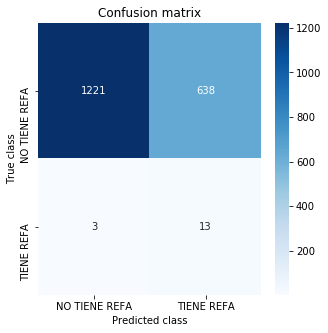

Recall: 0.8125
Precision: 0.0200
F1-score: 0.0390
G-mean: 0.7305
F-measure: 0.6287
AUCM = 0.39632


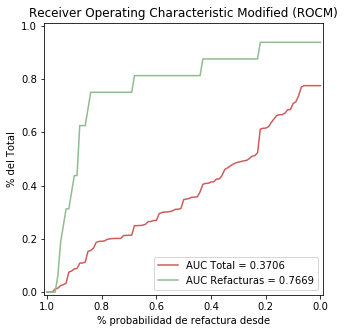

Porcentaje de Refacturas revisadas en limite de analista (3500) es 93.75% con un total de 1453 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.64% con un total de 477 registros a revisar.

Sector de facturacion 15
Codificacion lista
Dimensiones datos:  (2233, 846)
Dimensiones etiquetas:  (2233,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


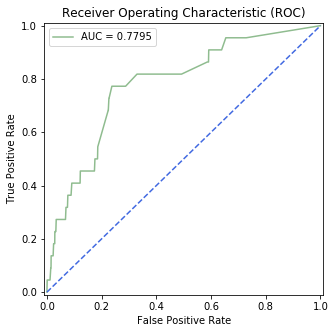

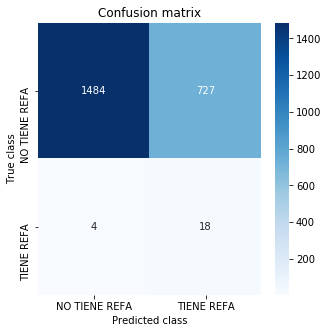

Recall: 0.8182
Precision: 0.0242
F1-score: 0.0469
G-mean: 0.7410
F-measure: 0.6772
AUCM = 0.33986


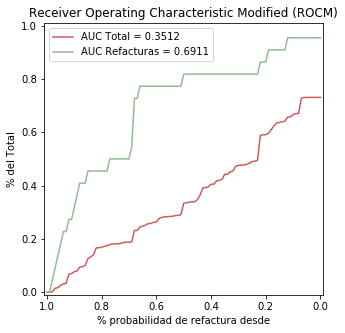

Porcentaje de Refacturas revisadas en limite de analista (3500) es 95.45% con un total de 1632 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.57% con un total de 631 registros a revisar.

Sector de facturacion 16
Codificacion lista
Dimensiones datos:  (2087, 846)
Dimensiones etiquetas:  (2087,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


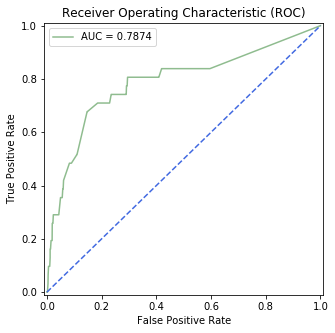

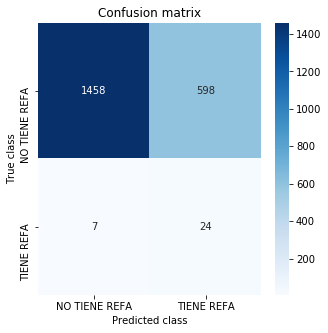

Recall: 0.7742
Precision: 0.0386
F1-score: 0.0735
G-mean: 0.7410
F-measure: 0.7460
AUCM = 0.33725


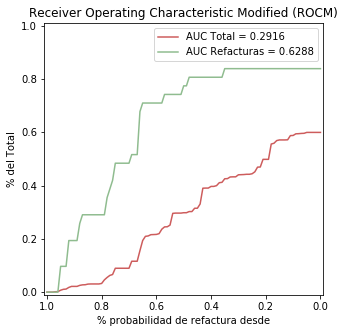

Porcentaje de Refacturas revisadas en limite de analista (3500) es 83.87% con un total de 1251 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.55% con un total de 525 registros a revisar.

Sector de facturacion 17
Codificacion lista
Dimensiones datos:  (2461, 846)
Dimensiones etiquetas:  (2461,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


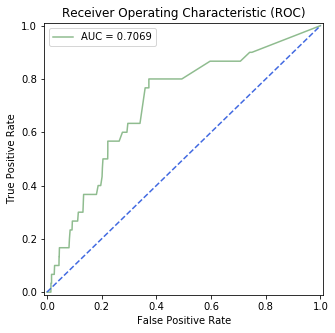

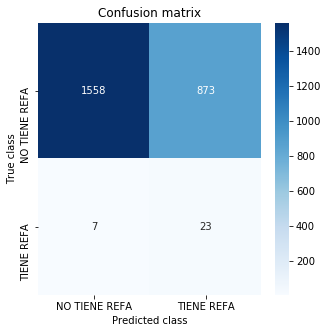

Recall: 0.7667
Precision: 0.0257
F1-score: 0.0497
G-mean: 0.7010
F-measure: 0.6616
AUCM = 0.25329


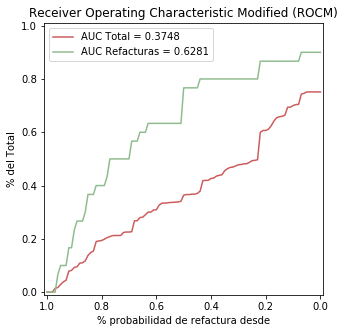

Porcentaje de Refacturas revisadas en limite de analista (3500) es 90.00% con un total de 1849 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.44% con un total de 933 registros a revisar.

Sector de facturacion 18
Codificacion lista
Dimensiones datos:  (2304, 846)
Dimensiones etiquetas:  (2304,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


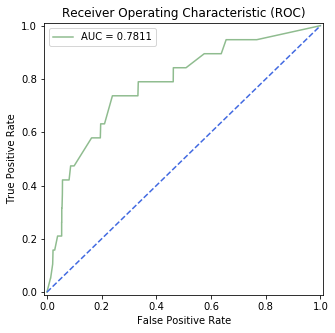

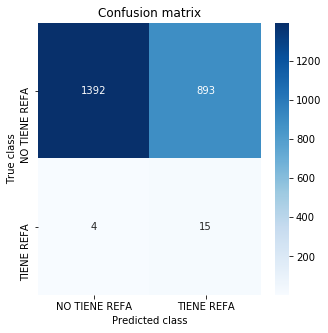

Recall: 0.7895
Precision: 0.0165
F1-score: 0.0324
G-mean: 0.6935
F-measure: 0.5720
AUCM = 0.34106


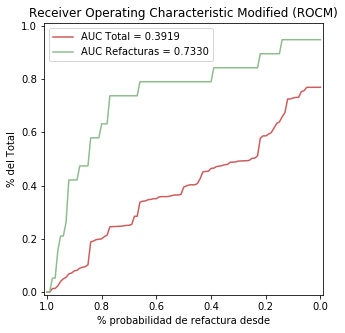

Porcentaje de Refacturas revisadas en limite de analista (3500) es 94.74% con un total de 1771 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.66% con un total de 778 registros a revisar.

Sector de facturacion 19
Codificacion lista
Dimensiones datos:  (1861, 846)
Dimensiones etiquetas:  (1861,)


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


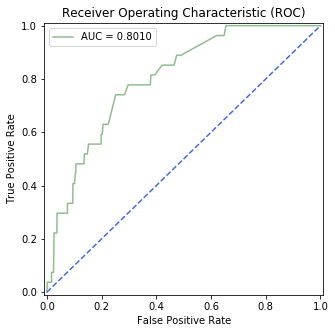

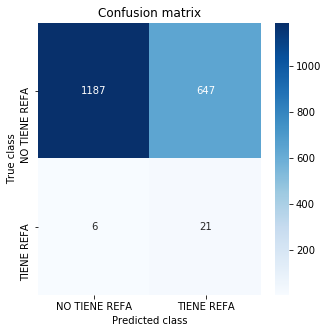

Recall: 0.7778
Precision: 0.0314
F1-score: 0.0604
G-mean: 0.7095
F-measure: 0.7099
AUCM = 0.35303


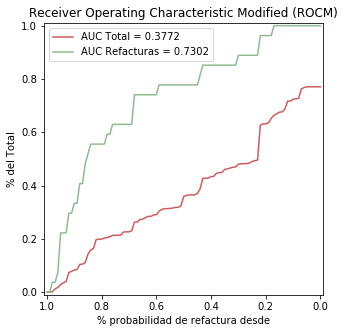

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1434 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.51% con un total de 603 registros a revisar.

Sector de facturacion 20


/opt/miniconda3/envs/jupyterhub/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Codificacion lista
Dimensiones datos:  (2000, 846)
Dimensiones etiquetas:  (2000,)


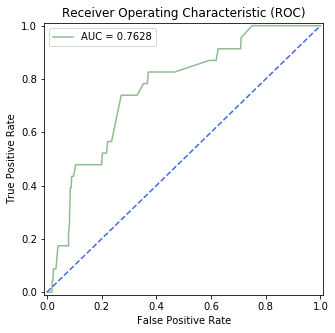

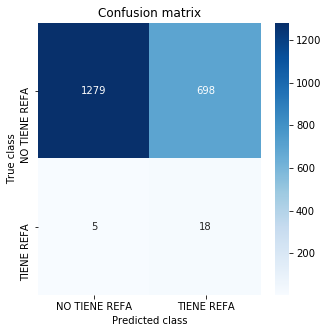

Recall: 0.7826
Precision: 0.0251
F1-score: 0.0487
G-mean: 0.7115
F-measure: 0.6664
AUCM = 0.31941


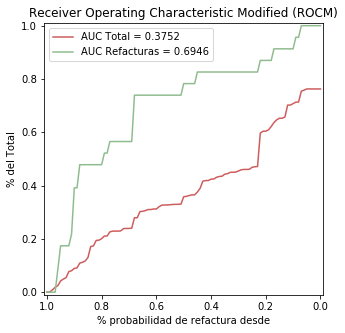

Porcentaje de Refacturas revisadas en limite de analista (3500) es 100.00% con un total de 1525 registros a revisar con el umbral de desicion 0.00
El umbral optimo de revision es 0.67% con un total de 558 registros a revisar.



In [6]:
start_time = datetime.now()
#crear variables para guardar resultados
recall = np.zeros(20)
precision = np.zeros(20)
f1_score = np.zeros(20)
g_mean = np.zeros(20)
f_beta = np.zeros(20)
AUCM = np.zeros(20)
umbral_limite = np.zeros(20)
refa_5analistas = np.zeros(20)
limite_5analistas = np.zeros(20)
maxima_diff = np.zeros(20)
maxima_diff_reg = np.zeros(20)
sector = np.zeros(20)
for i in range(0,20):
    sector[i] = i+1
#columnas para crear luego el dataframe con los resultados
columns_resultados = ['sector', 'recall', 'precision', 'f1_score', 'g_mean', 'f_beta', 'AUCM', 'umbral_limite', 'refa_5analistas',
                     'limite_5analistas', 'maxima_diff', 'maxima_diff_reg']
#paarametros de algunas metricas
umbral = 0.5
beta = 8
LABELS = ["NO TIENE REFA","TIENE REFA"]

# sectores para iterar
sectores = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']

w = 0
T = 'T1'
for sec in sectores:
    print('Sector de facturacion ' + sec)
    Data_test = Data_test1.drop(Data_test1[Data_test1['RECORR1']!=sec].index)
    
    
    # predicciones
    ohe = joblib.load('../ohe.pkl')
    mini = joblib.load('../mini.pkl')
    maxi = joblib.load('../maxi.pkl')
    SS = joblib.load('../SS.pkl')
    SS_num = joblib.load('../SS_num.pkl')
    le = joblib.load('../le.pkl')
    x_test, y_test = Preprocesamiento_Datos(Data_test, splits=False,
                                            ohe=ohe, mini=mini, maxi=maxi, SS=SS, SS_num=SS_num, le=le)
    
    predprob_y = decision_tree.predict_proba(x_test.tocsr())
    joblib.dump(predprob_y[:,1], 'predprob_y_v3-GXB-t1.pkl') #guardo las probabilidades de prediccion

    # grafica ROC
    fpr, tpr, threshold = metrics.roc_curve(y_test, predprob_y[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    curva_ROC(fpr, tpr, roc_auc)
    
    # matriz de confusion y metricas
    predprob_y = joblib.load('predprob_y_v3-GXB-t1.pkl')
    mostrar_resultados(y_test=y_test, pred_y=predprob_y, umbral=umbral)
    recall[w], precision[w], f1_score[w], g_mean[w], f_beta[w] = MOSTRAR_METRICAS(y_test=y_test, pred_y=predprob_y,
                                                                                  umbral=umbral, beta=beta)
    
    # ROCM y datos
    umbral_limite[w], refa_5analistas[w], limite_5analistas[w], maxima_diff[w], maxima_diff_reg[w], AUCM[w] = AUCM_PLOT('predprob_y_v3-GXB-t1.pkl')
    print('Porcentaje de Refacturas revisadas en limite de analista (3500) es %0.2f' % (refa_5analistas[w]*100) + '% ' +
          'con un total de %i' % limite_5analistas[w] + ' registros a revisar con el umbral de desicion %0.2f' % (umbral_limite[w]*100))
    print('El umbral optimo de revision es %0.2f' % maxima_diff[w] + '% ' + 'con un total de %i' % maxima_diff_reg[w] + ' registros a revisar.\n')
    
    #iterador
    w = w + 1

In [7]:
# guardar resultados de cada sector en archivo csv
matriz_resultados = np.vstack((sector, recall, precision, f1_score, g_mean, f_beta, AUCM, umbral_limite, refa_5analistas,
                              limite_5analistas, maxima_diff, maxima_diff_reg))
matriz_resultados = np.transpose(matriz_resultados)

Data_resultados =  pd.DataFrame(data=matriz_resultados, columns=columns_resultados)

Data_resultados.to_csv('Data_resultados_sectores_DIC18_DT.csv', sep=';', header=True, float_format='%.4f', encoding='utf-8')
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

Time elapsed (hh:mm:ss.ms) 0:01:21.833067


### Resultados NOV18

In [ ]:
# load the model from disk
#decision_tree = joblib.load('model_DT_V2.sav')